In [249]:
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

from sklearn.metrics import accuracy_score, f1_score

In [267]:
NAT_DATA_PATH = "C:/Users/dvirl/PycharmProjects/SemanticAnalysis/resources/data/natural_split/val.csv"
BT_DATA_PATH = "C:/Users/dvirl/PycharmProjects/SemanticAnalysis/resources/data/natural_split/val.csv"
AUG_MODEL_PATH = "C:/Users/dvirl/PycharmProjects/SemanticAnalysis/resources/indobert_tweet_classifier_aug.pt"
BT_MODEL_PATH = "C:/Users/dvirl/PycharmProjects/SemanticAnalysis/resources/indobert_tweet_classifier_bt.pt"
MODEL_NAME = "indolem/indobertweet-base-uncased"
NUM_LABELS=5

In [265]:
import torch
from transformers import AutoModel
from torch import nn

# Your model definition here
class IndoBertClassifier(nn.Module):
    def __init__(self, model_name=MODEL_NAME,
                 dense_1=64, dense_2=16, dropout=0.05, num_labels=5):
        super(IndoBertClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size

        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(hidden_size, dense_1)
        self.drop1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(dense_1, dense_2)
        self.fc3 = nn.Linear(dense_2, num_labels)
        self.act_relu = nn.ReLU()
        self.act_sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state
        x = embeddings.permute(0, 2, 1)
        x = self.pool(x).squeeze(-1)
        x = self.fc1(x)
        x = self.act_relu(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.act_relu(x)
        logits = self.fc3(x)
        out = self.act_sigmoid(logits)
        return out


In [268]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

aug_model = IndoBertClassifier(model_name=MODEL_NAME, num_labels=NUM_LABELS)
aug_model.load_state_dict(torch.load(AUG_MODEL_PATH, map_location="cpu"))
aug_model.eval()

bt_model = IndoBertClassifier(model_name=MODEL_NAME, num_labels=NUM_LABELS)
bt_model.load_state_dict(torch.load(BT_MODEL_PATH, map_location="cpu"))
bt_model.eval()


IndoBertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [269]:
df_orig = pd.read_csv(NAT_DATA_PATH)
df_aug = pd.read_csv(BT_DATA_PATH)
label2id = {'love': 0, 'anger': 1, 'sadness': 2, 'happy': 3, 'fear': 4}
id2label = {i: label for label, i in label2id.items()}

print("Label mapping:", label2id)

# Convert string labels to numeric
df_orig["label_id"] = df_orig["label"].map(label2id)
df_aug["label_id"] = df_aug["label"].map(label2id)

Label mapping: {'love': 0, 'anger': 1, 'sadness': 2, 'happy': 3, 'fear': 4}


In [270]:

class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [271]:

def create_dataloader(df, tokenizer, batch_size=16):
    dataset = TweetDataset(df['tweet'].tolist(), df['label_id'].tolist(), tokenizer)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)


loader_orig = create_dataloader(df_orig, tokenizer)
loader_aug = create_dataloader(df_aug, tokenizer)


In [272]:
def evaluate(model, dataloader):
    preds, labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            label = batch['label']

            outputs = model(input_ids, attention_mask)
            pred = torch.argmax(outputs, dim=1)

            preds.extend(pred.cpu().numpy())
            labels.extend(label.cpu().numpy())

    report = classification_report(labels, preds, output_dict=True)
    return report, preds, labels


In [273]:
%%time

aug_on_nat_preformance = evaluate(aug_model, loader_orig)
aug_on_bt_preformance = evaluate(aug_model, loader_aug)

bt_on_nat_preformance = evaluate(bt_model, loader_orig)
bt_on_bt_preformance = evaluate(bt_model, loader_aug)

CPU times: total: 9min 12s
Wall time: 2min 38s


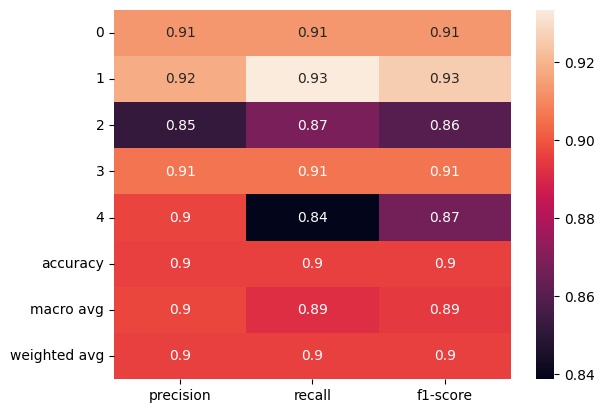

In [274]:
def plot_heatmap(report):
    import seaborn as sns
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)

plot_heatmap(aug_on_nat_preformance[0])



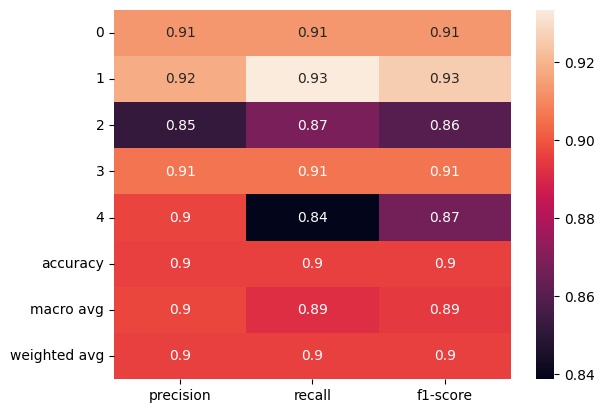

In [275]:
plot_heatmap(aug_on_bt_preformance[0])


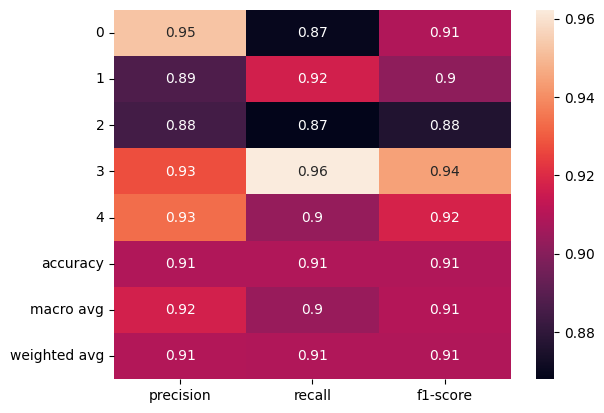

In [276]:

plot_heatmap(bt_on_nat_preformance[0])


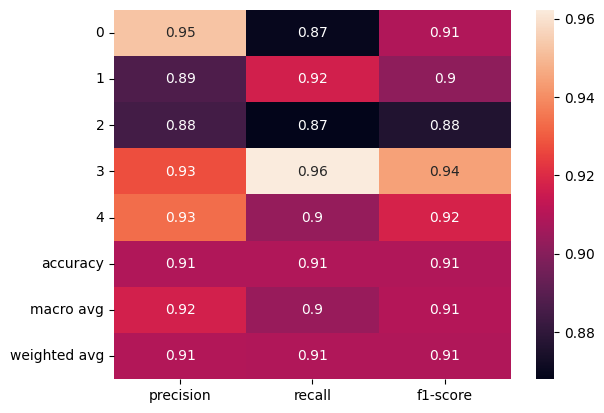

In [277]:
plot_heatmap(bt_on_bt_preformance[0])

In [278]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
def plot_confusion_matrix(preds, labels,):
    matrix = confusion_matrix(preds, labels, normalize="pred")

    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels = label2id.keys() )
    # Then just plot it:
    disp.plot(cmap="Blues")
    # And show it:
    plt.show()

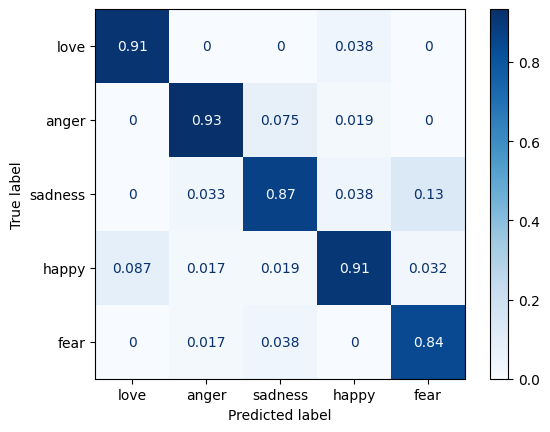

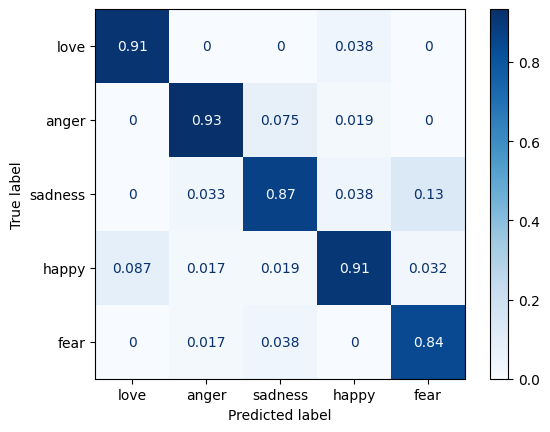

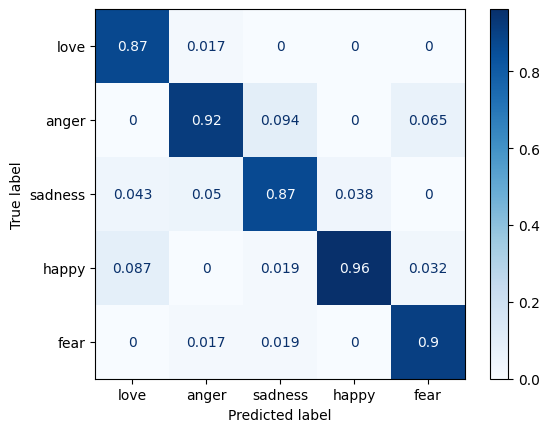

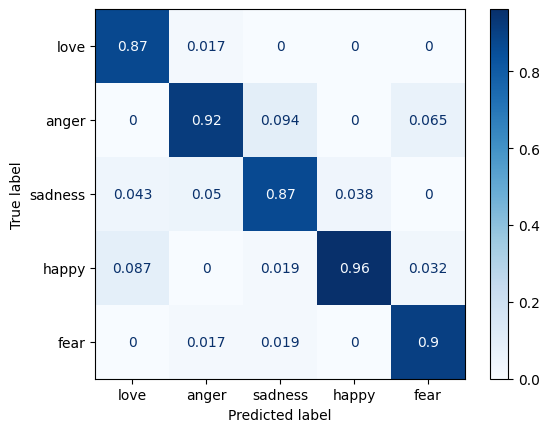

In [279]:
plot_confusion_matrix(aug_on_nat_preformance[1],aug_on_nat_preformance[2])
plot_confusion_matrix(aug_on_bt_preformance[1],aug_on_bt_preformance[2])

plot_confusion_matrix(bt_on_nat_preformance[1],bt_on_nat_preformance[2])
plot_confusion_matrix(bt_on_bt_preformance[1],bt_on_bt_preformance[2])